

*   **Setup**


> Only the **jpg** folder should be inside the flowers-102 folder. Delete all other **folders** inside that directory and then run the notebook.






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset folder
FOLDERNAME = 'fellowship_ai/data/flowers-102'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Python interpreter of the Colab VM can load
# python files from within it
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

from IPython.display import clear_output

# Matplotlib figures appear inline in the notebook
# rather than in a new window
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for the image dimentionality plot
%env HV_DOC_HTML=true  # for hvplot to show plots
!pip install panel==0.14.2 hvplot==0.8.4
!pip install Flask --upgrade
!pip install bokeh==2.4.3

# Reload external python modules
%load_ext autoreload
%autoreload 2
clear_output()

In [ ]:
sys.path[-1]

'/content/drive/My Drive/fellowship_ai/data/flowers-102'



*   Libraries and Directories



In [ ]:
import collections
import time
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

import torch
import torchvision
from torch import nn
from torch import optim, utils
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights

from scipy.io import loadmat
import numpy as np
import shutil
import os
import re
import cv2

# dirs
root = sys.path[-1]
images_dir = root + '/jpg'
train_dir = root + '/train'
valid_dir = root +  '/valid'
test_dir = root +  '/test'
best_model_path = root

print(root)
print(len(os.listdir(images_dir)))
# If the output of the following lines is not exactly 102
# then you need to uncomment the line "# # create_trn_val_tst_dirs()" in cell 7
# then comment it again
# print(len(os.listdir(train_dir)))
# print(len(os.listdir(valid_dir)))
# print(len(os.listdir(test_dir)))

/content/drive/My Drive/fellowship_ai/data/flowers-102
8189


In [ ]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
	print(f'Found {torch.cuda.device_count()} GPUs.')
	device = torch.device('cuda')
else:
	device = torch.device('cpu')

print('using device:', device)

Found 1 GPUs.
using device: cuda




*   **Hyperparameters**



In [ ]:
train_batchsize = 128
validate_batchsize = 128
epochs = 16
lr = 0.001



*   CPU cores to help loading data faster



In [ ]:
os.cpu_count()

2



*   Labels and Dataset Split




> The required directory structure to run this notebook

-> data

  -->> flowers-102

      --->>> jpg
      --->>> test
      --->>> train
      --->>> val
      --->>> setid.mat
      --->>> imagelables.mat






> If you're running the notebook for the **very first time** with the **appropriate directory structure** mentioned above, only then execute this function, otherwise if you have the /train, /valid, and /test directories in the /jpg directory already, **DO NOT** RUN the *create_trn_val_tst_dirs()* function



In [ ]:
set_ids = loadmat(root + '/setid.mat', squeeze_me=True)
labels = loadmat(root + '/imagelabels.mat')
print('split: ', set_ids)
print('all labels: ', labels['labels'][0])
print()
#################################################################################
# The test split is the biggest of the three splits, so it will be used as the  #
# training split and the original training split will be used as the test split #
#################################################################################
train_im_ids = set_ids['tstid'].tolist()  # training image indices
val_im_ids = set_ids['valid'].tolist()  # validation image indices
test_im_ids = set_ids['trnid'].tolist()  # testing image indices
print(f'train images ids: {train_im_ids[:5]} \ttotal train images ids: {len(train_im_ids)}')
print(f'val images ids: {val_im_ids[:5]}     \ttotal val images ids:  {len(val_im_ids)}')
print(f'test images ids: {test_im_ids[:5]}   \ttotal test images ids:  {len(test_im_ids)}')
print()

image_id_to_label = dict(enumerate((labels["labels"][0]).tolist(), 1))  # label dictionary
# print('image to labels: ', image_id_to_label)

image_sizes = {}
[image_sizes.setdefault(i, []) for i in range(1, len(labels['labels'][0]) + 1)]

for image in os.listdir(images_dir):
  current_id = int(re.sub('\D', '', image)[1::])
  im = Image.open(images_dir + '/' + image)
  # print(im.size[0], ' ', im.size[1])
  temp_tuple = [im.size[0], im.size[1]]  # width, height
  image_sizes[current_id].append(temp_tuple)
# im.show()

def create_trn_val_tst_dirs():
  """
    This function will COPY image files from the jpg folder to /train, /valid,
    and /test directories in the data directory. DO NOT run this a second time!!

    Inputs:
    - notinng

    Returns: Nothing, but copies images from /jpg dir to /train, /test, or
    /valid sub-dir
  """
  # Caution: Run only once
  if not os.path.exists(train_dir):
    print('!! Creating /train directory !!')
    os.makedirs(train_dir)
  if not os.path.exists(valid_dir):
    print('!! Creating /valid directory !!')
    os.makedirs(valid_dir)
  if not os.path.exists(test_dir):
    print('!! Creating /test directory !!')
    os.makedirs(test_dir)
  # Copying files from jpg to val, train, test dirs
  # We want to keep the original files just in case
  print('!!! Copying /jpg images into new directories !!!')
  for id in val_im_ids:
    shutil.copy(images_dir + f"/image_{id:05d}.jpg", valid_dir + f"/image_{id:05d}.jpg")

  for id in test_im_ids:
    shutil.copy(images_dir + f"/image_{id:05d}.jpg", test_dir + f"/image_{id:05d}.jpg")

  for id in train_im_ids:
    shutil.copy(images_dir + f"/image_{id:05d}.jpg", train_dir + f"/image_{id:05d}.jpg")

# Run this function only once when you've just downloaded the dataset
# Otherwise there will be multiple copies of images in those new dirs
# # # Uncomment only at the very beginning and comment it again # # #
create_trn_val_tst_dirs()

split:  {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009', '__version__': '1.0', '__globals__': [], 'trnid': array([6765, 6755, 6768, ..., 8026, 8036, 8041], dtype=uint16), 'valid': array([6773, 6767, 6739, ..., 8028, 8008, 8030], dtype=uint16), 'tstid': array([6734, 6735, 6737, ..., 8044, 8045, 8047], dtype=uint16)}
all labels:  [77 77 77 ... 62 62 62]

train images ids: [6734, 6735, 6737, 6742, 6743] 	total train images ids: 6149
val images ids: [6773, 6767, 6739, 6749, 6763]     	total val images ids:  1020
test images ids: [6765, 6755, 6768, 6736, 6744]   	total test images ids:  1020

image sizes:  {1: [[591, 500]], 2: [[625, 500]], 3: [[500, 667]], 4: [[667, 500]], 5: [[508, 500]], 6: [[535, 500]], 7: [[667, 500]], 8: [[667, 500]], 9: [[500, 510]], 10: [[667, 500]], 11: [[500, 748]], 12: [[530, 500]], 13: [[666, 500]], 14: [[645, 500]], 15: [[755, 500]], 16: [[752, 500]], 17: [[531, 500]], 18: [[751, 500]], 19: [[667, 500]], 20: [[762, 



*   Create class directories and move images accordingly for ImageLoader



In [ ]:
print(len(os.listdir(test_dir)))
print(len(os.listdir(train_dir)))
print(len(os.listdir(valid_dir)))

#################################################################################
# The test split is the biggest of the three splits, so it will be used as the  #
# training split and the original training split will be used as the test split #
#################################################################################

def move(directory):
  """
    Move images into respective class(label) directories

    Inputs:
    - directory: path to the directory which need its files moved
                 into class sub-directories e.g. /train

    Returns: Nothing, but moves images from parent dir to class sub-dir
    """
  for root, dirs, files in os.walk(directory):
    # for dir in dirs:
    #   print(dir)
    # print(len(dirs))
    for file in files:
      current_id = int(re.sub('\D', '', file)[1::])
      # print(f'File: {file} \tImage ID: {current_id} \tLabel: {image_id_to_label[current_id]}')
      # print(directory + '/' + file)
      # print(directory + '/' + str(image_id_to_label[current_id]) + '/' + file)
      # print()
      if not os.path.exists(directory + '/' + str(image_id_to_label[current_id])):
        os.makedirs(directory + '/' + str(image_id_to_label[current_id]))
        print(f'folder created for class {image_id_to_label[current_id]}')
      shutil.move(directory + '/' + file, directory + '/' + str(image_id_to_label[current_id]) + '/' + file)

# Execute only once !!!
# # # Uncomment all only after executing create_trn_val_tst_dirs() and comment them again # # #
move(test_dir)
move(valid_dir)
move(train_dir)
clear_output()
print('Done!')

Done!





*   **Exploratory Data Analysis**


> Class distribution in the dataset



77
258 40


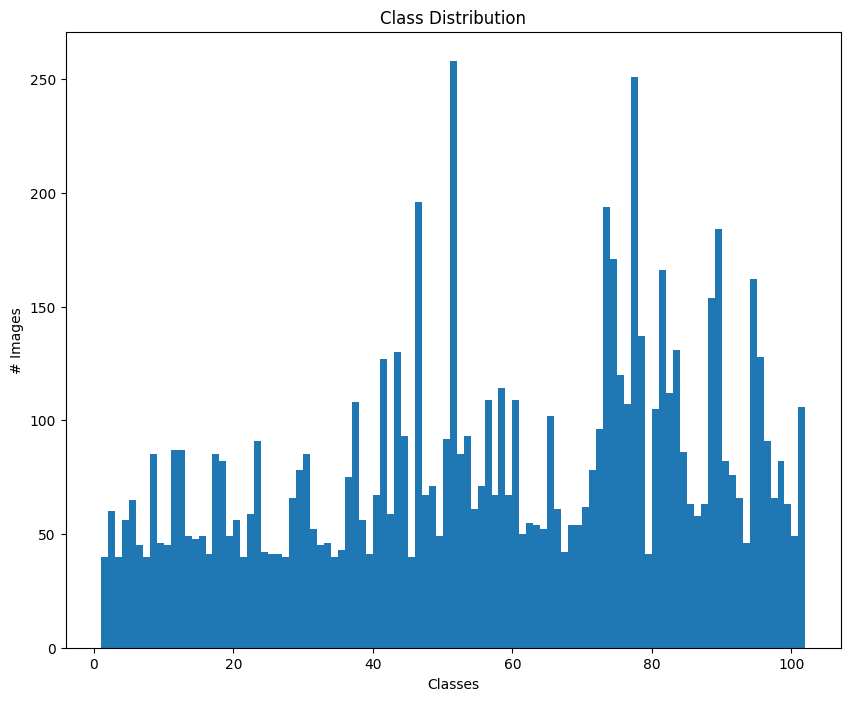

In [ ]:
# Class Disribution in the dataset
from collections import Counter

# check one label
print(labels['labels'][0][20])
L_1 = tuple(labels['labels'])
num_class_dict = Counter(L_1[0])
# print(num_class_dict[1])  # class 1 images
# print(num_class_dict[102])  # class 102 images

histogram = []
for i in range(1, 103):
  histogram.append(num_class_dict[i])
print(max(histogram), min(histogram))  # maximum and minimum num of images

# Plot class distribution
plt.ylabel('# Images')
plt.xlabel('Classes')
plt.title('Class Distribution')
plot = plt.hist(np.arange(1,103), np.arange(1,103), weights = histogram)
plt.savefig(root + "/class_distribution.png")



> Class distribution in the training split



238 20


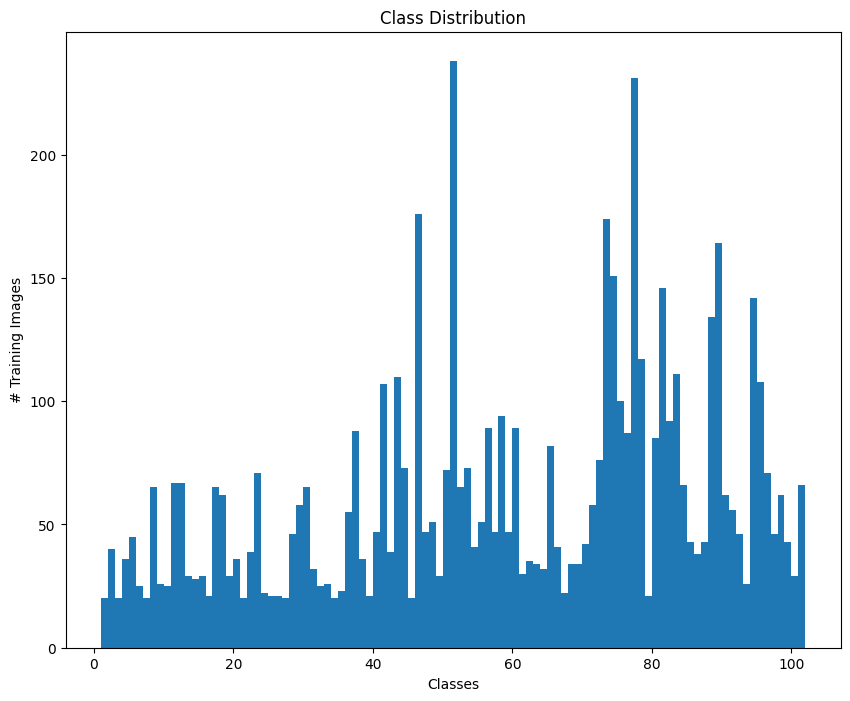

In [ ]:
# Class Disribution in training images
histogram_train_images = []
for i in range(1,103):
    histogram_train_images.append(len(os.listdir(train_dir + '/' + str(i))))  # images per class
print(max(histogram_train_images), min(histogram_train_images))

# Plot class distribution for training split
plt.ylabel('# Training Images')
plt.xlabel('Classes')
plt.title('Class Distribution')
plot = plt.hist(np.arange(1,103), np.arange(1,103), weights = histogram_train_images)
plt.savefig(root + "/class_distribution_train_split.png")



> Class distribution in the validation split



10 10


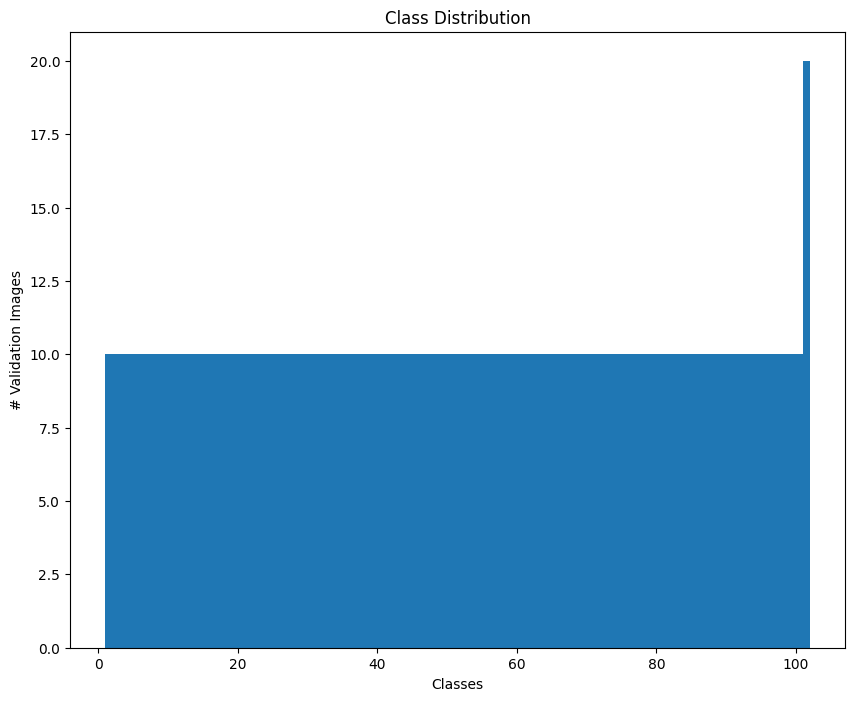

In [ ]:
# Class Disribution in validation images
histogram_valid_images = []
for i in range(1,103):
    histogram_valid_images.append(len(os.listdir(valid_dir + '/' + str(i))))  # images per class
print(max(histogram_valid_images), min(histogram_valid_images))

# Plot class distribution for validation split
plt.ylabel('# Validation Images')
plt.xlabel('Classes')
plt.title('Class Distribution')
plot = plt.hist(np.arange(1,103), np.arange(1,103), weights = histogram_valid_images)
plt.savefig(root + "/class_distribution_valid_split.png")



> Height vs Width in dataset images (with count)



In [ ]:
from dask import bag, diagnostics
import pandas as pd
import hvplot.pandas
import holoviews as hv

hv.extension('bokeh')

def get_dims(file):
    img = Image.open(file)
    h,w = img.size[1], img.size[0]
    return h,w

filelist = [images_dir + '/' + f for f in os.listdir(images_dir)]
dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()

dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(450,1200), ylim=(450,1200), grid=True, xticks=2,
        yticks=2, height=500, width=600, legend='bottom', title='Height vs Width in dataset images').options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
dim_df.describe()

,height,width
count,8189.000000,8189.000000
mean,534.352058,630.160581
std,75.453540,95.988254
min,500.000000,500.000000
25%,500.000000,501.000000
50%,500.000000,667.000000
75%,501.000000,699.000000
max,1168.000000,1024.000000


We can see that the minimum height and width of dataset images is 500 pixels. And the maximum varies from 1024 to 1168 pixels, while the mean height and width being 534 and 630 pixels respectively. This indicates that the dataset images are properly sized and do not have abruptly different dimensions.



> Height vs Width in dataset images (no count)



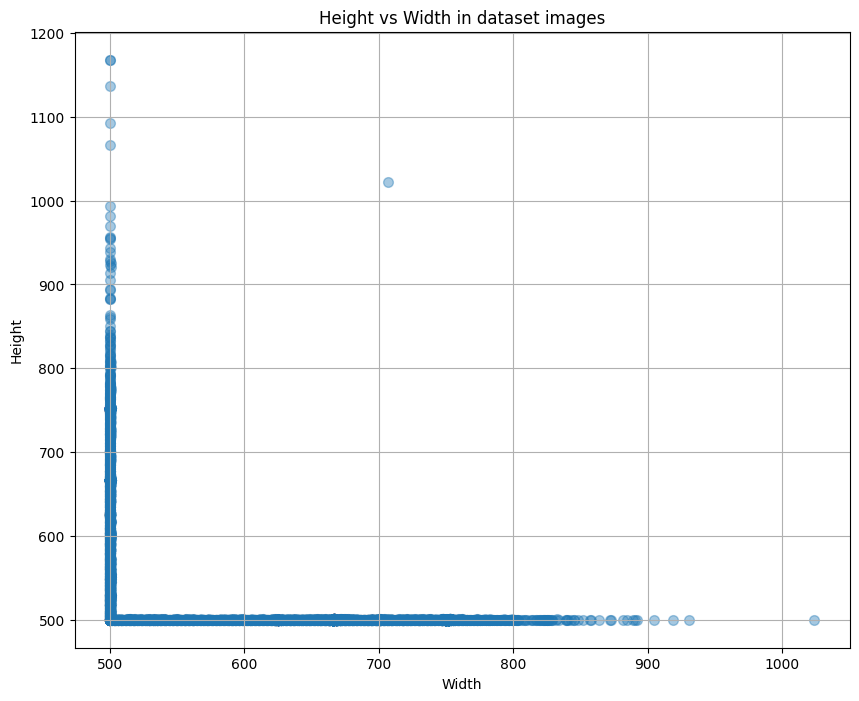

In [ ]:
size_lis = []
for keys, values in image_sizes.items():
  size_lis.append(values[0])
  # print(values[0])
# len(size_lis)
size_lis = np.asarray(size_lis)

x = np.array(size_lis[:, 0])
y = np.array(size_lis[:, 1])

hist, xbins, ybins = np.histogram2d(y, x, bins=range(6))
X, Y = np.meshgrid(xbins[:-1], ybins[:-1])
X = X[hist != 0]; Y = Y[hist != 0]
Z = hist[hist != 0]


fig, ax = plt.subplots()
ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_title("Height vs Width in dataset images")
ax.scatter(x, y, s=49, alpha=0.4)

for i in range(len(Z)):
    ax.annotate(str(int(Z[i])), xy=(X[i],Y[i]), xytext=(4,0),
                textcoords="offset points" )
# ax.legend()
ax.grid(True)
plt.show()



*   Data Augmentation using torchvision.transforms



In [ ]:
training_xforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # Normalize the data set with
                         [0.229, 0.224, 0.225]),  # ImageNet RGB std and mean
    ])

validation_xforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    ])

testing_xforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    ])


training_data = datasets.ImageFolder(train_dir, transform = training_xforms)
validation_data = datasets.ImageFolder(valid_dir, transform = validation_xforms)
testing_data = datasets.ImageFolder(test_dir, transform = validation_xforms)

train_loader = DataLoader(training_data, batch_size = train_batchsize, shuffle = True, num_workers = 2)
validate_loader = DataLoader(validation_data, batch_size = validate_batchsize, shuffle = True, num_workers = 2)
test_loader = DataLoader(testing_data, batch_size = validate_batchsize, shuffle = True, num_workers = 2)

In [ ]:
# Split -->> training: 75%, validation: 12.45%, testing: 12.45%
# Using the split in the original dataset
len(training_data), len(validation_data), len(testing_data), len(train_loader), len(validate_loader), len(test_loader)

(6149, 1020, 1020, 49, 8, 8)

In [ ]:
# Training batch
inputs, classes = next(iter(train_loader))
print(inputs.shape)

torch.Size([128, 3, 224, 224])




*   Visualize some examples



torch.Size([4, 3, 224, 224])


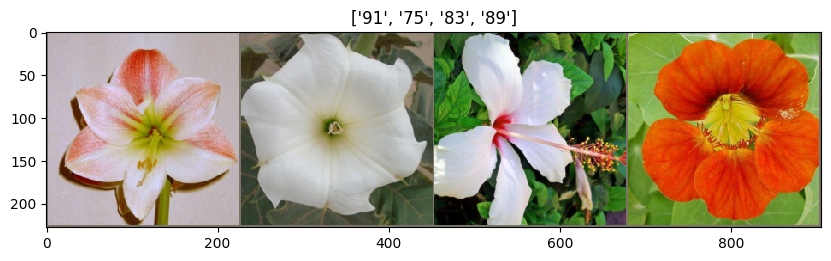

In [ ]:
# Loading a temporary batch of 4 random training images to display
temp_training_xform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
    ])

temp_training_data = datasets.ImageFolder(train_dir, transform = temp_training_xform)
temp_train_loader = DataLoader(temp_training_data, batch_size = 4, shuffle = True)
temp_inputs, temp_classes = next(iter(temp_train_loader))
print(temp_inputs.shape)

# Reference: PyTorch Transfer Learning tutorial
# {https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html}
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

out = torchvision.utils.make_grid(temp_inputs, nrow=5)

imshow(out, title=[temp_training_data.classes[x] for x in temp_classes])



*   Finetuning ResNet50


> Loading a pretrained ResNet50 model and resetting the final fully connected layer






In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  # better accuracy with previous weights

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.2MB/s]


In [ ]:
# Parameter of newly constructed modules have requires_grad = True by default
total_feats = model.fc.in_features

# We want the fully-connected layer to have 102 outputs
# As this is a relatively small dataset we reinitialize only this layer
model.fc = nn.Linear(total_feats, 102)  # 102: total classes

# Get model on GPU if available
model = model.to(device)

In [ ]:
# Loss function commonly used for classification
loss_func = nn.CrossEntropyLoss()

# Parameters of final layer are being optimized only and not the entire model
# optimizer = optim.SGD(model.fc.parameters(), lr = 0.005, momentum = 0.9)  # less accuracy
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)
# optimizer = optim.Adamax(model.fc.parameters())
# optimizer = torch.optim.NAdam(model.fc.parameters())  # not good
# optimizer = torch.optim.RMSprop(model.fc.parameters(), lr = 0.01)

# Learning rate decay by 0.1 every 6 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 6, gamma = 0.1)



*   Classification accuracy on Validation or Test data split



In [ ]:
def check_accuracy(loader, model, loss_function):
    """
    Validate the results

    Inputs:
    - model: A PyTorch Module giving the model to train
    - loss function: Loss function used to calculate loss
    - loader: Validation Loader or Test Loader

    Returns: Nothing, but prints model accuracies during training
    """
    if loader == validate_loader:
      print('\nChecking validation accuracy...')
    else:
      print('\nChecking testing accuracy...')
    valid_loss = 0.0
    val_correct = 0
    val_samples = 0
    model.eval()  #  evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device)
            y = y.to(device = device)
            scores = model(x)
            # print(scores.shape)
            loss = loss_function(scores, y)
            _, preds = scores.max(1)
            valid_loss += loss.item()
            val_correct += (preds == y).sum()
            val_samples += preds.size(0)
        acc = float(val_correct) / val_samples
        print('Got %d / %d correct (%.2f)' % (val_correct, val_samples, 100 * acc))
    return valid_loss, acc



*   Training loop



In [ ]:
import time

def train_eval_part3(model, optimizer, scheduler, epochs, loss_function, train_loader, validate_loader):
    """
    Train the ResNet50 on Flower102 using the PyTorch Module API

    Inputs:
    - model: A PyTorch Module giving the model to train
    - optimizer: An Optimizer object we will use to train the model
    - epochs: A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training
    """
    start_time = time.time()
    training_losses, validation_losses = [], []
    best_valid_acc = -1
    torch.save(model.state_dict(), best_model_path + '/model_resnet50Flower102.pt')

    for epoch in range(1, epochs):
      train_loss = 0.0
      val_loss = 0.0
      train_correct = 0
      train_samples = 0

      model.train()  # put model to training mode
      for t, (x, y) in enumerate(train_loader):
        x = x.to(device=device)  # inputs
        y = y.to(device=device)  # labels

        # Zero out all the gradients
        optimizer.zero_grad()

        scores = model(x)  # ^y^ / outputs
        loss = loss_function(scores, y)

        # Backwards pass: gradient of loss wrt each parameter of the model
        loss.backward()
        # Parameter update using backward pass gradients
        optimizer.step()

        train_loss += loss.item()
      # scheduler.step()

      val_loss, val_accuracy = check_accuracy(validate_loader, model, loss_function)
      train_loss = train_loss / len(train_loader.dataset)
      val_loss = val_loss / len(validate_loader.dataset)

      training_losses.append(train_loss)
      validation_losses.append(val_loss)

      print('Training Loss: {:.6f}, \tValidation Loss: {:.6f}'.format(train_loss, val_loss))
      print('Epoch Accuracy: {:.6f}'.format(val_accuracy*100))

      # Find the best val_accuracy
      # Deep copy the model if accuracy has increased
      if best_valid_acc < val_accuracy:
        print('Validation Accuracy has increased from '+ f'{best_valid_acc*100:.5f}'+' to ' + f'{val_accuracy*100:.5f}')
        best_valid_acc = val_accuracy
        torch.save(model.state_dict(), best_model_path + '/model_resnet50Flower102.pt')

      print("<<<<<<<<<<<<<<<<<<<<<<<<-------------- End of Epoch {} ---------------->>>>>>>>>>>>>>>>>>>>>>>>".format(epoch))
    end_time = time.time()
    total_time = end_time - start_time
    time_per_epoch_sec = total_time / epochs
    print()
    print(f'Best Validation Accuracy ----->>>>> {best_valid_acc*100}')
    print('Total time: %5.2f seconds' % (total_time))
    print('Time per epoch: %5.2f seconds' % (time_per_epoch_sec))
    model.load_state_dict(torch.load(best_model_path + '/model_resnet50Flower102.pt'))

    return model, training_losses, validation_losses

In [ ]:
model, training_losses, validation_losses = train_eval_part3(
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    epochs = 16,
    loss_function = loss_func,
    train_loader = train_loader,
    validate_loader = validate_loader
)


Checking validation accuracy...
Got 543 / 1020 correct (53.24)
Training Loss: 0.024737, 	Validation Loss: 0.016476
Epoch Accuracy: 53.235294
Validation Accuracy has increased from -100.00000 to 53.23529
<<<<<<<<<<<<<<<<<<<<<<<<-------------- End of Epoch 1 ---------------->>>>>>>>>>>>>>>>>>>>>>>>

Checking validation accuracy...
Got 798 / 1020 correct (78.24)
Training Loss: 0.012071, 	Validation Loss: 0.008877
Epoch Accuracy: 78.235294
Validation Accuracy has increased from 53.23529 to 78.23529
<<<<<<<<<<<<<<<<<<<<<<<<-------------- End of Epoch 2 ---------------->>>>>>>>>>>>>>>>>>>>>>>>

Checking validation accuracy...
Got 863 / 1020 correct (84.61)
Training Loss: 0.008304, 	Validation Loss: 0.006002
Epoch Accuracy: 84.607843
Validation Accuracy has increased from 78.23529 to 84.60784
<<<<<<<<<<<<<<<<<<<<<<<<-------------- End of Epoch 3 ---------------->>>>>>>>>>>>>>>>>>>>>>>>

Checking validation accuracy...
Got 890 / 1020 correct (87.25)
Training Loss: 0.006724, 	Validation Loss: 



*   Visualize predictions on training images



In [ ]:
# Reference: PyTorch Transfer Learning tutorial
# {https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html}
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {training_data.classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

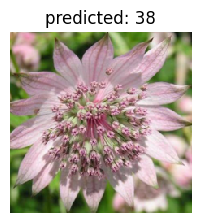

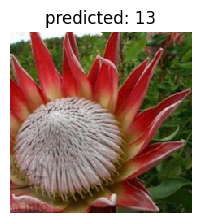

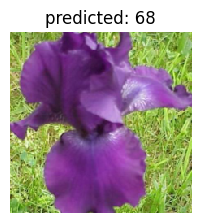

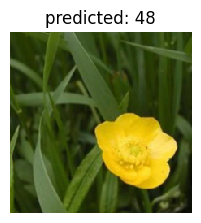

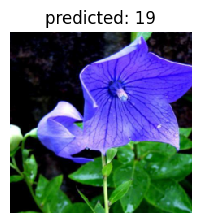

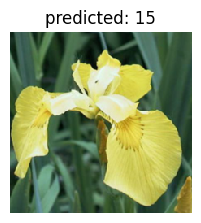

In [ ]:
visualize_model(model)



*   Inference on custom images



In [ ]:
# Reference: PyTorch Transfer Learning tutorial
# {https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html}
def visualize_custom_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = testing_xforms(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {training_data.classes[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

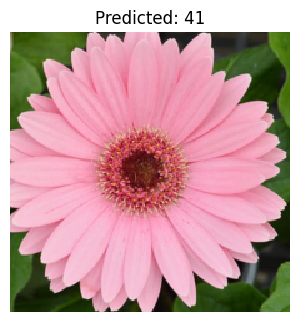

In [ ]:
model.load_state_dict(torch.load(best_model_path + '/model_resnet50Flower102.pt'))

visualize_custom_predictions(
    model,
    img_path = root + '/barbeton_daisy_inference.jpg'  # petunia label = 51; barbeton label = 41
)

plt.ioff()
plt.show()



*   Testing the model



In [ ]:
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Load model for Inference i.e. load the trained weights
model.load_state_dict(torch.load(best_model_path + '/model_resnet50Flower102.pt'))

# Check test accuracy
check_accuracy(test_loader, model, loss_func)


Checking testing accuracy...
Got 933 / 1020 correct (91.47)


(2.6351953744888306, 0.9147058823529411)



*   Plots


> Training vs Validation Losses





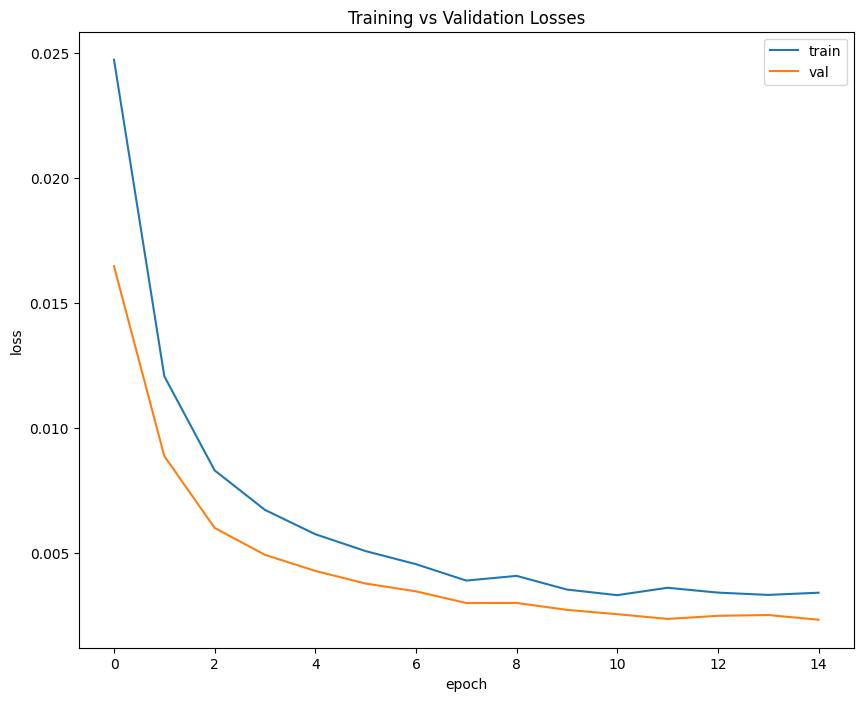

In [ ]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training vs Validation Losses')
plt.show()



*   **Delete** the **/train**, **/test**, and **/valid** folders in the flowers-120 directory

